In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.misc.statistics import *
from spyrit.misc.disp import *
from spyrit.misc.matrix_tools import *
from spyrit.core.Preprocess import *
from spyrit.core.Forward_Operator import *

In [2]:
img_size = 64 # image size
M = 1024    # number of measurements
alpha = 5000     # Image intensity (in photons)
bs = 10 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Pmat = np.dot(Perm,H);
Pmat = Pmat[:M,:];

In [6]:
x = inputs.view(b*c,w*h)

x = torch.tensor(np.random.random([batch_size,img_size]), dtype=torch.float)## Instantiate Forward Operators

In [7]:
FO = Forward_operator(Pmat)
FO_Split = Forward_operator_Split(Pmat)
FO_Split_ft_had = Forward_operator_Split_ft_had(Pmat, Perm, w, h)

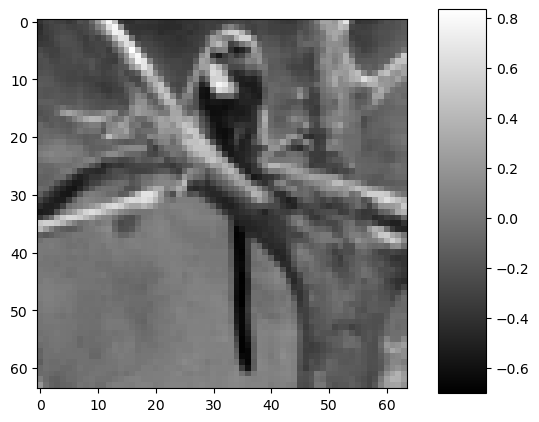

In [8]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# Split_diag_poisson_preprocess

In [9]:
SPP = Preprocess_Split_diag_poisson(alpha, M, w*h)

## forward

In [10]:
y_FO_Split = FO_Split(x)
y = SPP(y_FO_Split,FO_Split)

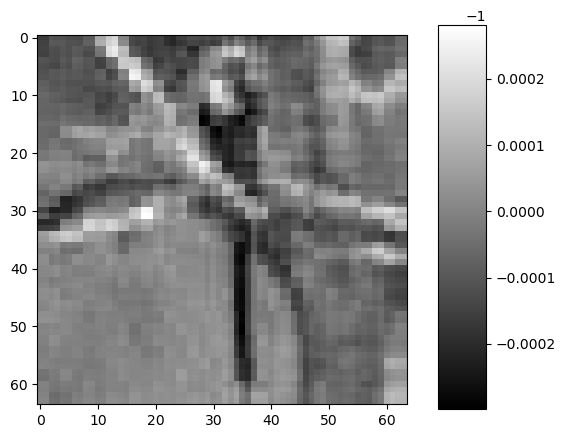

In [11]:
x_est = FO_Split.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

## sigma

In [12]:
y_sigma = SPP.sigma(y_FO_Split)

## sigma_expe

In [13]:
x.shape

torch.Size([10, 4096])

In [14]:
y_sigma_expe = SPP.sigma_expe(x, gain=1, mudark=0, sigdark=0, nbin=1)

TypeError: sigma_expe() got an unexpected keyword argument 'gain'

## sigma_from_image

In [ ]:
y_sigma_from_image = SPP.sigma_from_image(x, FO_Split)

### forward_expe

In [ ]:
forward_expe_y = SPP.forward_expe(FO_Split(x), FO_Split_ft_had)
print(forward_expe_y[0].shape)

### denormalize_expe

In [ ]:
x.shape

In [ ]:
x = x.view(b*c,1,h,w)
norm = torch.tensor(9, dtype=float)
denormalize_expe_y = SPP.denormalize_expe(x, norm, h, w)

## Preprocess_shift_poisson

### Instantiate

In [ ]:
PSP = Preprocess_shift_poisson(alpha, M, w*h)

### forward

In [ ]:
y_PSP = PSP(x, FO)